In [ ]:
!pip install dynesty

In [ ]:
from scipy.optimize import minimize
import numpy as np
from scipy.special import logsumexp
from scipy.stats import norm, uniform
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt

import dynesty

In [ ]:
df = pd.read_csv('M32_0722.csv')
import importlib
import FunctionsM32 as FM
importlib.reload(FM)
df = FM.iterate_R_disk_convergence(df, max_iter=100, tol_inclination=0.01, tol_PA=0.35, D_M31=776.2, print=True)

df.to_csv('M32_0722.csv', index=False)



KeyError: 'theta_j'

In [ ]:
df = pd.read_csv('M32_Final.csv')
theta_j = df['theta_j'].values
i_j_rad = df['i_j_rad'].values
v_helio = df['v_helio'].values
v_rot_model = df['v_rot_model'].values



KeyError: 'theta_j'

In [ ]:
import FunctionsM32 as FM

df = pd.read_csv("M32_0722.csv")
print(len(df))
v_offset, v_model_los = FM.calculate_voffset(1.21, v_rot_model, theta_j, i_j_rad, v_helio)
# Figure 및 Subplots 설정
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 첫 번째 히스토그램: V_rot_model_los
axes[0].hist(v_model_los, bins=16, color='blue', alpha=0.7)
axes[0].set_xlabel('V_rot_model_los (km/s)')
axes[0].set_ylabel('Frequency')
axes[0].set_title( r'Histogram of Rotational $V_{LoS}$ Model')



# 두 번째 히스토그램: v_offset
axes[1].hist(v_offset, bins=16, color='blue', alpha=0.7)
axes[1].set_xlabel('V_offset (km/s)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(r'Histogram of offset $V_{LoS}$ Model')

print(len(v_offset))
# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

KeyError: 'theta_j'

Let's compare

#1 all stars (2049) for n components == 3, 5 (4 skip)  
#2 serendipitous stars (680) for n components == 3, 5 (4 skip)  
#3 clear stars (1583) for n components == 3, 5 (4 skip)

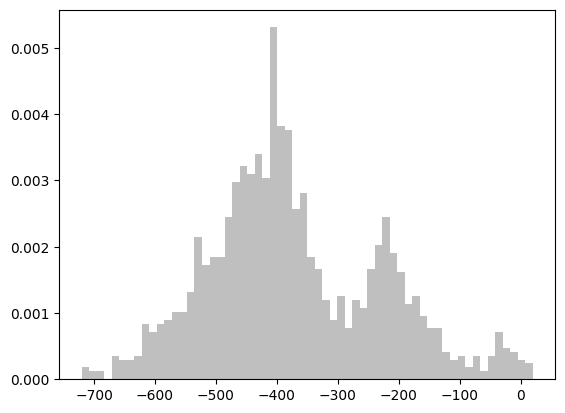

In [ ]:
from scipy.stats import norm, uniform


def sample_choose(df_raw, ser = False, clear = False, contam = False, target = False):
    """
    ser == True: serendipitous stars (680)
    clear == True: clear stars (1583)
    """
    if ser:
        df = df_raw[df_raw['TYPE'] == 'serendip']
    elif clear:
        df = df_raw[df_raw['CONTAM'] < 0.2]
    elif contam:
        df = df_raw[df_raw['CONTAM'] >= 0.2]
    elif target:
        df = df_raw[df_raw['TYPE'] == 'target']
    else:
        df = df_raw.copy()

    return df


df_raw = pd.read_csv("M32_0722.csv")


df_allstar = sample_choose(df_raw, ser=False, clear=False, contam=False)  # Modify this part!!! (2049개)
df_target = sample_choose(df_raw, ser=False, clear=False, contam=False, target=True)  # Target stars (400개)
df_ser = sample_choose(df_raw, ser=True, clear=False, contam=False)  # Serendipitous stars (680개)
df_clear = sample_choose(df_raw, ser=False, clear=True, contam=False)  # Clear stars (1583개)
df_contam = sample_choose(df_raw, ser=False, clear=False, contam=True)  # Contaminated stars (386개)

df = [df_allstar, df_ser, df_clear, df_contam]

plt.hist(df_target['v_helio'], bins=60, density=True, alpha=0.5, label='Contaminated', color='gray')


def input_data(df):
    """
    df: DataFrame containing the data
    Returns: theta_j, i_j_rad, v_helio, v_rot_model
    """
    theta_j = df['theta_j'].values
    i_j_rad = df['i_j_rad'].values
    v_helio = df['v_helio'].values
    v_rot_model = df['v_rot_model'].values

    return theta_j, i_j_rad, v_helio, v_rot_model



def log_likelihood_3comp(theta):
    sigma_disk, f1, mu1, sigma1, f2, mu2, sigma2, f3, mu3, sigma3, f4, mu4, sigma4,f_rot = theta
    disk_weight = 1.0 - (f1 + f2)  # f3, f4 not using here
    if disk_weight < 0 or any(f < 0 for f in (f1, f2)):
        return -np.inf
    if any(s <= 0 for s in (sigma_disk, sigma1, sigma2)):
        return -np.inf

    try:
        v_offset, v_model_los = FM.calculate_voffset(f_rot, v_rot_model, theta_j, i_j_rad, v_helio)
    except:
        return -np.inf
        # likelihood 계산
    pdf_vals = (
            disk_weight * norm.pdf(v_offset, loc=0.0, scale=sigma_disk) +
            f1 * norm.pdf(v_helio, loc=mu1, scale=sigma1) +
            f2 * norm.pdf(v_helio,loc=mu2, scale=sigma2)
        )
    return np.sum(np.log(pdf_vals + 1e-300))

def log_likelihood_4comp_GSS(theta):
    sigma_disk, f1, mu1, sigma1, f2, mu2, sigma2, f3, mu3, sigma3, f4, mu4, sigma4,f_rot = theta
    disk_weight = 1.0 - (f1 + f2 + f4)  # f3 not using here
    if disk_weight < 0 or any(f < 0 for f in (f1, f2, f4)):
        return -np.inf
    if any(s <= 0 for s in (sigma_disk, sigma1, sigma2, sigma4)):
        return -np.inf
    try:
        v_offset, v_model_los = FM.calculate_voffset(f_rot, v_rot_model, theta_j, i_j_rad, v_helio)
    except:
        return -np.inf
        # likelihood 계산
    pdf_vals = (
            disk_weight * norm.pdf(v_offset, loc=0.0, scale=sigma_disk) +
            f1 * norm.pdf(v_helio, loc=mu1, scale=sigma1) +
            f2 * norm.pdf(v_helio, loc=mu2, scale=sigma2) +
            f4 * norm.pdf(v_helio, loc=mu4, scale=sigma4)
        )
    return np.sum(np.log(pdf_vals + 1e-300))

def log_likelihood_4comp_MW(theta):
    sigma_disk, f1, mu1, sigma1, f2, mu2, sigma2, f3, mu3, sigma3, f4, mu4, sigma4, f_rot = theta
    disk_weight = 1.0 - (f1 + f2 + f3)  # f4 not using here
    if disk_weight < 0 or any(f < 0 for f in (f1, f2, f3)):
        return -np.inf
    if any(s <= 0 for s in (sigma_disk, sigma1, sigma2, sigma3)):
        return -np.inf
    try:
        v_offset, v_model_los = FM.calculate_voffset(f_rot, v_rot_model, theta_j, i_j_rad, v_helio)
    except:
        return -np.inf
        # likelihood calculation
    pdf_vals = (
            disk_weight * norm.pdf(v_offset, loc=0.0, scale=sigma_disk) +
            f1 * norm.pdf(v_helio, loc=mu1, scale=sigma1) +
            f2 * norm.pdf(v_helio, loc=mu2, scale=sigma2) +
            f3 * norm.pdf(v_helio, loc=mu3, scale=sigma3)
        )
    return np.sum(np.log(pdf_vals + 1e-300))

def log_likelihood_5comp(theta):
    sigma_disk, f1, mu1, sigma1, f2, mu2, sigma2, f3, mu3, sigma3, f4, mu4, sigma4,f_rot = theta
    disk_weight = 1.0 - (f1 + f2 + f3+ f4)
    if disk_weight < 0 or any(f < 0 for f in (f1, f2,f3,f4)):
        return -np.inf
    if any(s <= 0 for s in (sigma_disk, sigma1, sigma2,sigma3, sigma4)):
        return -np.inf
    try:
        v_offset, v_model_los = FM.calculate_voffset(f_rot, v_rot_model, theta_j, i_j_rad, v_helio)
    except:
        return -np.inf
        # likelihood 계산
    pdf_vals = (
            disk_weight * norm.pdf(v_offset, loc=0.0, scale=sigma_disk) +
            f1 * norm.pdf(v_helio, loc=mu1, scale=sigma1) +
            f2 * norm.pdf(v_helio, loc=mu2, scale=sigma2) +
            f3 * norm.pdf(v_helio, loc=mu3, scale=sigma3) +
            f4 * norm.pdf(v_helio, loc=mu4, scale=sigma4)
        )
    return np.sum(np.log(pdf_vals + 1e-300))

In [ ]:
from dynesty import DynamicNestedSampler
import multiprocessing
import numpy as np
import FunctionsM32 as FM
importlib.reload(FM)

prior = FM.create_prior_distributions_5D()
prior_list = list(prior.values())

# Prior distribution output
print("Prior distributions:")
for key, dist in prior.items():
    print(f"{key:10s}: {dist}")

# 2. prior_transform define
def prior_transform(u):
    eps = 1e-6
    u = np.clip(u, eps, 1 - eps)
    return [dist.ppf(ui) for dist, ui in zip(prior_list, u)]
# 3. Dynesty Dynamic Sampler setting
ndim = len(prior)



KeyError: 'theta_j'

In [ ]:
samples = [df_target, df_ser, df_clear, df_contam]
# Minjae  : df_targetstar
# Rhett   : df_ser
# Yashika : df_clear
# Nishyanth : df_contam

dsamplers = {}         # Dictionary to store samplers by model name
results_comp = {}      # Dictionary to store results by model name

# Define likelihood functions for each model
# comment out 3,4,4,
likelihoods = {
    "3comp": log_likelihood_3comp,
    "4comp_GSS": log_likelihood_4comp_GSS,
    "4comp_MW": log_likelihood_4comp_MW,
    "5comp": log_likelihood_5comp
}

# Choose the sample data to analyze
theta_j, i_j_rad, v_helio, v_rot_model = input_data(df_ser)  # Select your sample here

# Run nested sampling for each model
for model_name, likelihood_function in likelihoods.items():
    dsampler = DynamicNestedSampler(
        likelihood_function,
        prior_transform,
        ndim=ndim,
        bound='multi',
        sample='rwalk'
    )

    dsampler.run_nested(dlogz_init=0.5, print_progress=True)

    # Store sampler and result in dictionaries
    dsamplers[model_name] = dsampler
    results_comp[model_name] = dsampler.results



KeyError: 'theta_j'

In [ ]:
from dynesty import plotting as dyplot
import matplotlib.pyplot as plt

# Define sample labels (if you are plotting by model name, use model_labels)
model_labels = {
    "3comp": "3-Component",
    "4comp_GSS": "4-Component (GSS)",
    "4comp_MW": "4-Component (MW)",
    "5comp": "5-Component"
}

# Assuming prior is a dictionary with parameter names
param_labels = list(prior.keys())

# Plotting corner plots for each model result
for model_name, result in results_comp.items():
    fig, axes = dyplot.cornerplot(
        result,
        show_titles=True,
        title_fmt=".2f",
        labels=param_labels
    )
    fig.suptitle(f"Posterior Corner Plot: {model_labels[model_name]}", fontsize=14)
    plt.tight_layout()
    plt.show()


NameError: name 'prior' is not defined

In [ ]:
import numpy as np
import pandas as pd

# Define parameter names from prior (or use custom labels)
param_names = list(prior.keys())

# Labels for model types used in analysis
model_labels = {
    "3comp": "3-Component",
    "4comp_GSS": "4-Component (GSS)",
    "4comp_MW": "4-Component (MW)",
    "5comp": "5-Component"
}

# Storage for summary statistics
medians_all = {}
cred_intervals_all = {}

# Compute statistics for each model's posterior samples
for model_name, res in results_comp.items():
    samples = res.samples  # Shape: (n_samples, n_params)

    # Compute percentiles
    q16, q50, q84 = np.percentile(samples, [16, 50, 84], axis=0)

    # Median (50th percentile)
    medians_all[model_name] = dict(zip(param_names, q50))

    # Symmetric 68% credible intervals
    ci_dict = {
        name: (low, high)
        for name, low, high in zip(param_names, q16 - q50, q84 - q50)
    }
    cred_intervals_all[model_name] = ci_dict

# Convert to DataFrames
df_medians = pd.DataFrame.from_dict(medians_all, orient='index')
df_cred_intervals = pd.DataFrame.from_dict(cred_intervals_all, orient='index')

# Rename columns for credible intervals
df_cred_intervals.columns = [f"{col}_68CI" for col in df_cred_intervals.columns]

# Save to CSV
df_medians.to_csv('medians_summary.csv')
df_cred_intervals.to_csv('cred_intervals_summary.csv')

print("✅ Summary statistics saved: 'medians_summary.csv' and 'cred_intervals_summary.csv'")


✅ Summary statistics saved: 'medians_summary.csv' and 'cred_intervals_summary.csv'


In [ ]:
import pandas as pd
import numpy as np
import re

# --- 신뢰구간 문자열 파싱 ---
def parse_np_float_tuple(cell_str):
    if not isinstance(cell_str, str) or not cell_str.strip():
        return (np.nan, np.nan)
    try:
        matches = re.findall(r'[-+]?\d*\.\d+(?:[eE][-+]?\d+)?', cell_str)
        if len(matches) >= 2:
            return float(matches[0]), float(matches[1])
    except:
        pass
    return (np.nan, np.nan)

# --- 수학 기호로 바꾸는 매핑 함수 ---
def format_param_latex(param):
    if param == 'f_rot':
        return r"$f_{\mathrm{rot}}$"
    elif param == 'sigma_disk':
        return r"$\sigma_{\mathrm{disk}}$"
    match = re.match(r'(f|mu|sigma)(\d)', param)
    if match:
        sym, idx = match.groups()
        symbol_map = {'f': 'f', 'mu': r'\mu', 'sigma': r'\sigma'}
        return f"${symbol_map[sym]}_{{{idx}}}$"
    return f"${param}$"

# --- 데이터 불러오기 ---
df_medians = pd.read_csv("medians_summary.csv", index_col=0)
df_cred = pd.read_csv("cred_intervals_summary.csv", index_col=0)

# --- LaTeX 테이블 초기화 ---
latex_table = pd.DataFrame(index=df_medians.columns, columns=df_medians.index)

# --- 변환 및 포매팅 ---
for model in df_medians.index:
    for param in df_medians.columns:
        try:
            median = df_medians.loc[model, param]
            ci_col = f"{param}_68CI"
            if ci_col not in df_cred.columns:
                latex_str = ""
            else:
                ci_entry = df_cred.loc[model, ci_col]
                ci_low, ci_high = parse_np_float_tuple(ci_entry)
                if pd.isna(median) or np.isnan(ci_low) or np.isnan(ci_high):
                    latex_str = ""
                else:
                    minus_err = abs(ci_low)
                    plus_err = abs(ci_high)
                    latex_str = f"${median:.2f}^{{+{plus_err:.2f}}}_{{-{minus_err:.2f}}}$"
        except Exception as e:
            print(f"[❌ Error] {model}, {param} → {e}")
            latex_str = ""
        latex_table.loc[param, model] = latex_str

# --- 컬럼명 재정의 ---
latex_table.columns = [
    "3-Component",
    "4-Component (GSS)",
    "4-Component (MW)",
    "5-Component"
]

# --- 파라미터 순서 ---
params = latex_table.index.tolist()
cols = latex_table.columns.tolist()

# --- LaTeX 출력 ---
print("\\begin{tabular}{l" + "c" * len(cols) + "}")
print("\\toprule")
print("Parameter & " + " & ".join(cols) + " \\\\")
print("\\midrule")

for param in params:
    param_label = format_param_latex(param)
    row = [latex_table.loc[param, col] if pd.notna(latex_table.loc[param, col]) else "" for col in cols]
    print(f"{param_label} & {' & '.join(row)} \\\\")

print("\\bottomrule")
print("\\end{tabular}")

\begin{tabular}{lcccc}
\toprule
Parameter & 3-Component & 4-Component (GSS) & 4-Component (MW) & 5-Component \\
\midrule
$\sigma_{\mathrm{disk}}$ & $83.05^{+6.63}_{-8.10}$ & $80.54^{+7.17}_{-9.13}$ & $83.84^{+6.98}_{-8.46}$ & $81.33^{+7.15}_{-9.64}$ \\
$f_{1}$ & $0.37^{+0.06}_{-0.07}$ & $0.38^{+0.06}_{-0.07}$ & $0.35^{+0.07}_{-0.08}$ & $0.35^{+0.08}_{-0.08}$ \\
$\mu_{1}$ & $-331.90^{+9.16}_{-9.02}$ & $-331.37^{+9.06}_{-8.85}$ & $-338.36^{+8.95}_{-9.21}$ & $-338.73^{+8.87}_{-8.70}$ \\
$\sigma_{1}$ & $140.31^{+6.59}_{-7.94}$ & $139.12^{+7.02}_{-8.18}$ & $133.13^{+7.15}_{-7.15}$ & $132.15^{+7.34}_{-7.77}$ \\
$f_{2}$ & $0.22^{+0.03}_{-0.03}$ & $0.22^{+0.03}_{-0.03}$ & $0.22^{+0.03}_{-0.03}$ & $0.22^{+0.03}_{-0.04}$ \\
$\mu_{2}$ & $-198.94^{+3.00}_{-2.99}$ & $-199.09^{+3.14}_{-3.00}$ & $-199.01^{+3.08}_{-2.93}$ & $-199.22^{+3.23}_{-2.92}$ \\
$\sigma_{2}$ & $32.61^{+2.93}_{-3.51}$ & $32.63^{+3.05}_{-3.54}$ & $32.48^{+2.96}_{-3.37}$ & $32.65^{+2.96}_{-4.01}$ \\
$f_{3}$ & $0.49^{+0.35}_{-0.33}

In [ ]:
import pandas as pd

def summarize_parameters(param_names, dynesty_values,escala_values=None, mode='mean'):
    """
    Compare parameter values from dynesty output and Escala (if given).

    - dynesty_values: list or array of dynesty-derived values (mean or MAP)
    - escala_values: optional list of reference values (e.g., from Escala+09)
    """
    data = {'Parameter': param_names, f'{mode.title()} (This Work)': dynesty_values}
    if escala_values is not None:
        data['Escala'] = escala_values
        data['Difference'] = [d - e for d, e in zip(dynesty_values, escala_values)]
    df = pd.DataFrame(data)
    return df

escala_list_5comp= [91.8, 0.37, -340.9, 148.9, 0.08, -191.9, 27.5, 0.02, -55.5, 58.9, 0.02, -607.5, 25.8, 0.96]
escala_list_M32region_3comp = [45.4, 0.68, -334.9, 143.0, 0.19, -195.6, 31.5, 1.18]
summarize_parameters(param_names=list(priors.keys()),
                     dynesty_values=mean_params,
                     escala_values=escala_list_M32region_3comp,  # 여기에 Escala+09 값을 넣으세요
                     mode='mean')

Seems to have more disk stars, halo comp is decreased dramatically.
- Assume disk LOS-v as -389.2 km/s

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde

def plot_3components_fitting(posterior_representative, v_range=np.linspace(-700, 200, 1000)):
    """
    param_dict : posterior mean values
    Plot only M32, M31 halo, MWFG, and GSS components in v_helio space.
    """
    mean_los_mod = -389.2  # M31 disk LOS velocity, assumed constant
    # 각 component
    components = [
    {'label': 'M31disk',  'f':1 - posterior_representative[1]-posterior_representative[4],  'mu': mean_los_mod,  'sigma': posterior_representative[0]},
    {'label': 'M31Halo',  'f': posterior_representative[1],  'mu': posterior_representative[2],  'sigma': posterior_representative[3]},
    {'label': 'M32', 'f': posterior_representative[4],  'mu': posterior_representative[5],  'sigma': posterior_representative[6]}
    #{'label': 'MWFG', 'f': posterior_representative[7],  'mu': posterior_representative[8],  'sigma': posterior_representative[9]},
    #{'label': 'GSS',  'f': posterior_representative[10], 'mu': posterior_representative[11], 'sigma': posterior_representative[12]},
]

    # 각 컴포넌트별 PDF
    v_helio = df_raw['v_helio']
    comp_pdfs = [comp['f'] * norm.pdf(v_helio, loc=comp['mu'], scale=comp['sigma']) for comp in components]


    kde = gaussian_kde(v_helio, bw_method='scott')  # or 'silverman' or scalar
    v_range = np.linspace(min(v_helio) - 50, max(v_helio) + 50, 1000)
    pdf_kde = kde(v_range)

    # 3. 시각화
    plt.figure(figsize=(10, 6))
    plt.hist(v_helio, bins=60, density=True, alpha=0.5, label='Observed v_helio', color='gray')
    #plt.plot(v_range, pdf_kde, label='KDE Fit', color='black', linewidth=2)
    #plt.plot(v_range, total_pdf, label="Sum of Components", color='black', linewidth=2)

    colors = ['blue', 'green', 'orange']
    total_pdf = np.zeros_like(v_range)

    # 먼저 blue, green, orange 컴포넌트 그리기
    for comp, color in zip(components[:3], colors):
        label = f"{comp['label']} (f={comp['f']:.3f})"
        pdf = comp['f'] * norm.pdf(v_range, loc=comp['mu'], scale=comp['sigma'])
        total_pdf += pdf
        plt.plot(v_range, pdf, label=label, color=color)

    # 마지막 purple은 앞의 3개를 합한 총합으로
    plt.plot(v_range, total_pdf, label='Sum of all components', color='purple', linestyle='--')


def plot_5components_fitting(posterior_representative, v_range=np.linspace(-700, 200, 1000)):
    """
    param_dict : posterior mean values
    Plot only M32, M31 halo, MWFG, and GSS components in v_helio space.
    """
    mean_los_mod = -389.2  # M31 disk LOS velocity, assumed constant
    # 각 component
    components = [
    {'label': 'M31disk',  'f':1 - posterior_representative[1]-posterior_representative[4]-posterior_representative[7]-posterior_representative[10],  'mu': mean_los_mod,  'sigma': posterior_representative[0]},
    {'label': 'M31Halo',  'f': posterior_representative[1],  'mu': posterior_representative[2],  'sigma': posterior_representative[3]},
    {'label': 'M32', 'f': posterior_representative[4],  'mu': posterior_representative[5],  'sigma': posterior_representative[6]},
    {'label': 'MWFG', 'f': posterior_representative[7],  'mu': posterior_representative[8],  'sigma': posterior_representative[9]},
    {'label': 'GSS',  'f': posterior_representative[10], 'mu': posterior_representative[11], 'sigma': posterior_representative[12]},
]

    # 각 컴포넌트별 PDF
    v_helio = df_raw['v_helio']
    comp_pdfs = [comp['f'] * norm.pdf(v_helio, loc=comp['mu'], scale=comp['sigma']) for comp in components]


    kde = gaussian_kde(v_helio, bw_method='scott')  # or 'silverman' or scalar
    v_range = np.linspace(min(v_helio) - 50, max(v_helio) + 50, 1000)
    pdf_kde = kde(v_range)

    # 3. 시각화
    plt.figure(figsize=(10, 6))
    plt.hist(v_helio, bins=60, density=True, alpha=0.5, label='Observed v_helio', color='gray')
    #plt.plot(v_range, pdf_kde, label='KDE Fit', color='black', linewidth=2)
    #plt.plot(v_range, total_pdf, label="Sum of Components", color='black', linewidth=2)

    colors = ['blue', 'green', 'orange', 'red', 'cyan']
    total_pdf = np.zeros_like(v_range)

    # 먼저 blue, green, orange 컴포넌트 그리기
    for comp, color in zip(components[:5], colors):
        label = f"{comp['label']} (f={comp['f']:.3f})"
        pdf = comp['f'] * norm.pdf(v_range, loc=comp['mu'], scale=comp['sigma'])
        total_pdf += pdf
        plt.plot(v_range, pdf, label=label, color=color)

    # 마지막 purple은 앞의 3개를 합한 총합으로
    plt.plot(v_range, total_pdf, label='Sum of all components', color='purple', linestyle='--')


    plt.xlabel("v_helio [km/s]")
    plt.ylabel("Probability Density")
    plt.title("Velocity Components (excluding Disk)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
plot_5components_fitting(map_params)   # If number of components is 3
#plot_5components_fitting(map_params)  # If number of components is 5
